In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

## Data Exploration

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2021-06-24 17:53:39--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M   569KB/s    in 2m 23s  

2021-06-24 17:56:03 (416 KB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



In [ ]:
!unzip -nq UCI-HAR.zip

In [ ]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [ ]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x
  
  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x
  
  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1

  return Xtrain, Ytrain, Xtest, Ytest

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

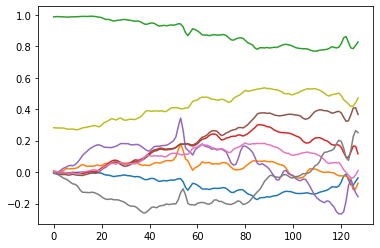

In [ ]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [ ]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
# x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [ ]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=10,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/10
230/230 [==============================] - 10s 9ms/step - loss: 1.0601 - accuracy: 0.7563 - val_loss: 0.7151 - val_accuracy: 0.8195
Epoch 2/10
230/230 [==============================] - 2s 8ms/step - loss: 0.4757 - accuracy: 0.8908 - val_loss: 0.4287 - val_accuracy: 0.8680
Epoch 3/10
230/230 [==============================] - 2s 8ms/step - loss: 0.2863 - accuracy: 0.9146 - val_loss: 0.3722 - val_accuracy: 0.8609
Epoch 4/10
230/230 [==============================] - 2s 8ms/step - loss: 0.2221 - accuracy: 0.9248 - val_loss: 0.3198 - val_accuracy: 0.8744
Epoch 5/10
230/230 [==============================] - 2s 7ms/step - loss: 0.1835 - accuracy: 0.9340 - val_loss: 0.3059 - val_accuracy: 0.8941
Epoch 6/10
230/230 [==============================] - 2s 8ms/step - loss: 0.1637 - accuracy: 0.9372 - val_loss: 0.2778 - val_accuracy: 0.9046
Epoch 7/10
230/230 [==============================] - 2s 8ms/step - loss: 0.1859 - accuracy: 0.9263 - val_loss: 0.2695 - val_accuracy: 0.8907
Epoch

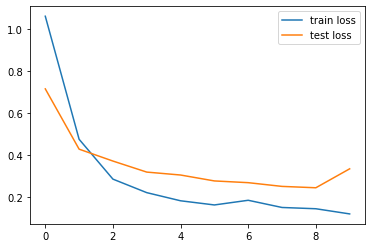

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

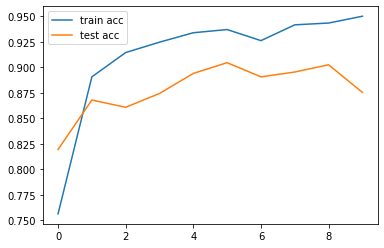

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [ ]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# make predictions
Ptest = best_model.predict(Xtest)

In [ ]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

0.9026128266033254

In [ ]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)
  
  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)
  
  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [ ]:
D_feat = feat_train.shape[1]

In [ ]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(32, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

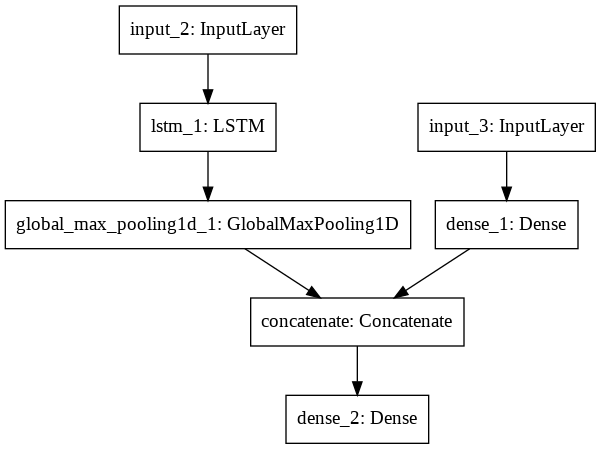

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [ ]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 4s 10ms/step - loss: 0.3265 - accuracy: 0.8878 - val_loss: 0.2229 - val_accuracy: 0.9182
Epoch 2/15
230/230 [==============================] - 2s 8ms/step - loss: 0.1073 - accuracy: 0.9618 - val_loss: 0.2003 - val_accuracy: 0.9226
Epoch 3/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0774 - accuracy: 0.9735 - val_loss: 0.1754 - val_accuracy: 0.9355
Epoch 4/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0599 - accuracy: 0.9792 - val_loss: 0.1649 - val_accuracy: 0.9403
Epoch 5/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0498 - accuracy: 0.9820 - val_loss: 0.1792 - val_accuracy: 0.9352
Epoch 6/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0524 - accuracy: 0.9812 - val_loss: 0.2151 - val_accuracy: 0.9247
Epoch 7/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0495 - accuracy: 0.9818 - val_loss: 0.2035 - val_accuracy: 0.9298
Epoch

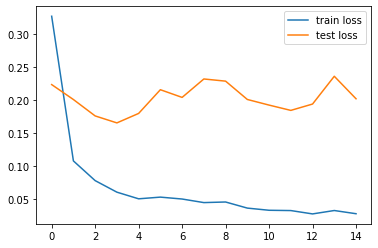

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

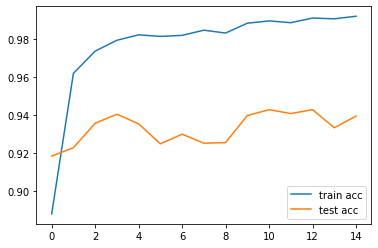

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [ ]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

In [ ]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

0.9426535459789617